In [58]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from utils.preprocess_text_column import preprocess_text_column
from utils.gender_guess import gender_guess
from utils.preprocess_complete import preprocess_complete
from utils.plot_bar_with_style import plot_bar_with_style

# from utils.train_models_and_stacking_REGRESSOR import (
#     train_models_and_stacking_REGRESSOR,
# )
import joblib
from utils.plot_correlacao import plot_correlacao
from sklearn.model_selection import train_test_split

In [37]:
# Carregamento
df = pd.read_csv('data/teste_indicium_precificacao.csv')
row = {'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 'Entire home/apt',
 'price': 225,
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355}

# Concatenar
df = pd.concat([df, pd.DataFrame([row])])
print(df.drop_duplicates().shape)
print(df.shape)
df.tail(1)

(48894, 16)
(48895, 16)


,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355


---

## Exploração (EDA)
O objetivo da exploração de dados numa tarefa de aprendizado de máquina é gerar insights para escolha dos métodos de cada uma das próximas etapas da tarefa.

In [3]:
df.head(3)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

In [5]:
# Se não instalada
#!pip install missingno
# Observar aonde tem dados faltantes
import missingno as mi

#mi.matrix(df)
#plt.show()

- As colunas ultima_review, reviews_por_mes possuem dados faltantes e deve ser tratada na etapa de pré-preprocessamento
- A coluna price é categórica e deve ser tratada na etapa de pré-preprocessamento
- Utilizaremos 6.0 MB para armazenar a tabela na memória

In [6]:
# explorando categóricas (estatísticas)
df['room_type'].value_counts()

room_type
Entire home/apt    25409
Private room       22325
Shared room         1160
Name: count, dtype: int64

In [7]:
# explorando numéricas (estatísticas)
df.describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,4.889400e+04,4.889400e+04,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,38842.000000,48894.000000,48894.000000
mean,1.901753e+07,6.762139e+07,40.728951,-73.952169,152.720763,7.030085,23.274758,1.373251,7.144005,112.776169
std,1.098288e+07,7.861118e+07,0.054529,0.046157,240.156625,20.510741,44.550991,1.680453,32.952855,131.618692
min,2.595000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.472371e+06,7.822737e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967743e+07,3.079553e+07,40.723075,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915225e+07,1.074344e+08,40.763117,-73.936273,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


O preço mediano é de 152.720763, com uma estadia mínima de 7 noites em média.

## Explorando numéricas (gráficos)

### Mapa de Calor

In [8]:
import folium
from folium.plugins import MarkerCluster, HeatMap

def plot_heatmap_incidencia_geografica(df, radius=12, blur=15):
    # Determinando o ponto central do mapa
    central_latitude = df['latitude'].mean()
    central_longitude = df['longitude'].mean()

    # Criando o mapa com uma localização central e um zoom inicial
    mapa = folium.Map(location=[central_latitude, central_longitude], zoom_start=11, control_scale=True)

    # Dados para o Heatmap (pares de latitude e longitude)
    heat_data = [[row['latitude'], row['longitude']] for index, row in df.iterrows()]

    # Adicionando o Heatmap ao mapa com parâmetros ajustados para maior visibilidade
    HeatMap(heat_data, radius=radius, blur=blur).add_to(mapa)

    # Agrupamento dos marcadores para melhor visualização
    marker_cluster = MarkerCluster().add_to(mapa)

    # Adicionando marcadores ao mapa
    for idx, row in df.iterrows():
        popup_text = f"Grupo do Bairro: {row['bairro_group']}"
        folium.Marker(location=[row['latitude'], row['longitude']],
                      popup=popup_text,
                      icon=folium.Icon(color='blue', icon='info-sign')
                     ).add_to(marker_cluster)

    return mapa

# Exemplo de uso
#mapa = plot_heatmap_incidencia_geografica(df)
#display(mapa)
#mapa.save('mapa_heatmap.html')  # Para salvar o mapa em um arquivo HTML


### Matriz de Correlação entre Características Numéricas

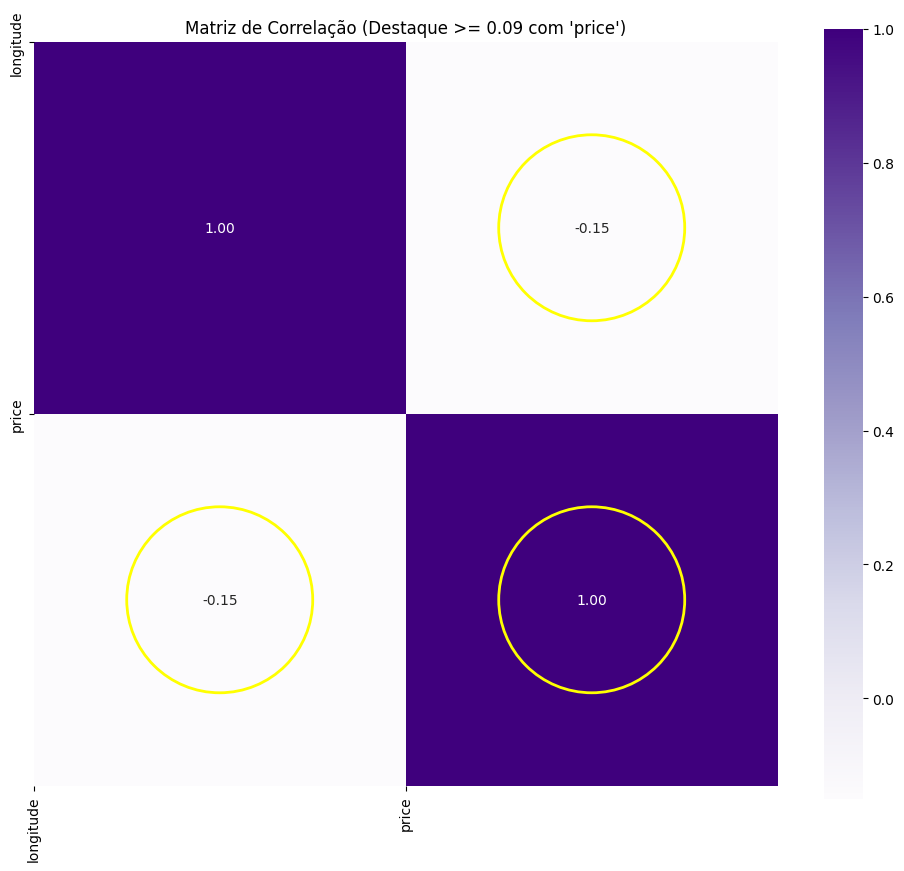

In [9]:
# Plotando a correlação entre as características numéricas
plot_correlacao(df, valor_minimo_correlacao=0.09)

# Apenas a coluna longitudade apresenta 1 correlação acima de 0.09

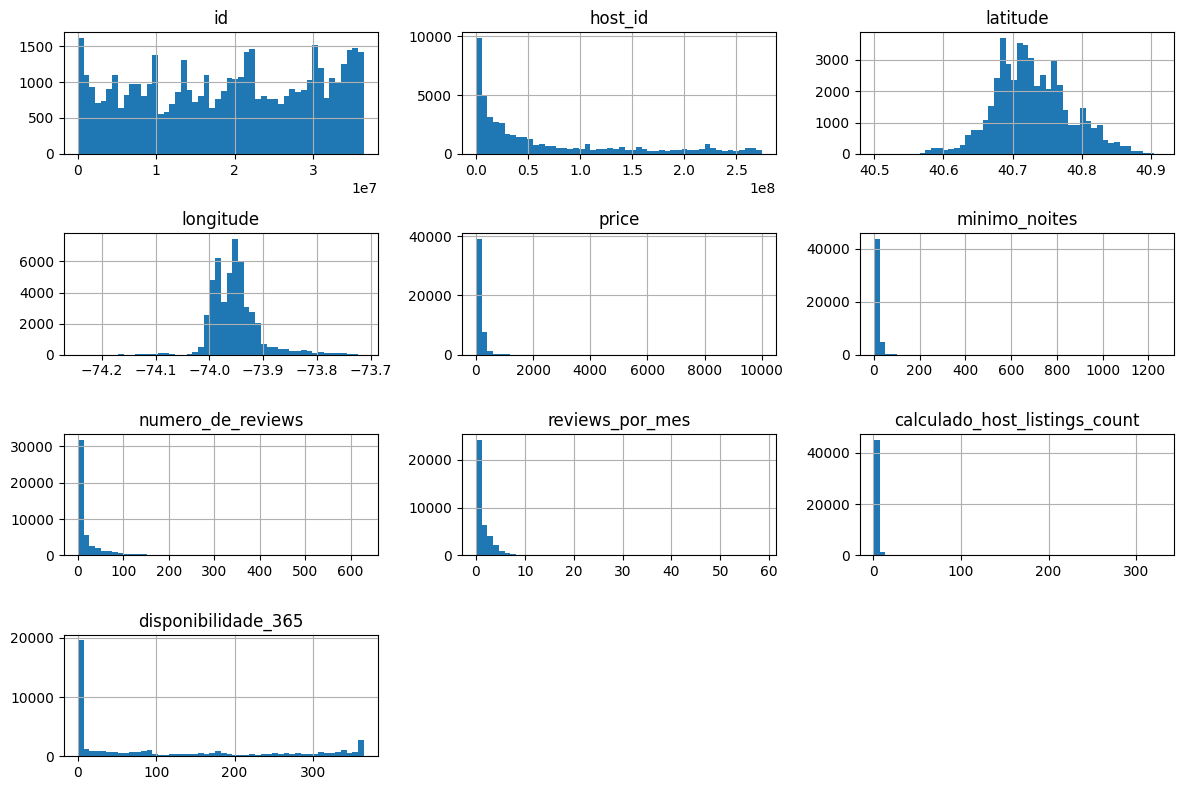

In [10]:
# Histogramas numéricas
df.hist(bins=50, figsize=(12, 8))
plt.tight_layout()
plt.show()

Existem várias distribuições assimétricas presentes, o que sugere que modelos baseados na hipótese de que os dados seguem uma distribuição normal podem produzir resultados insatisfatórios.

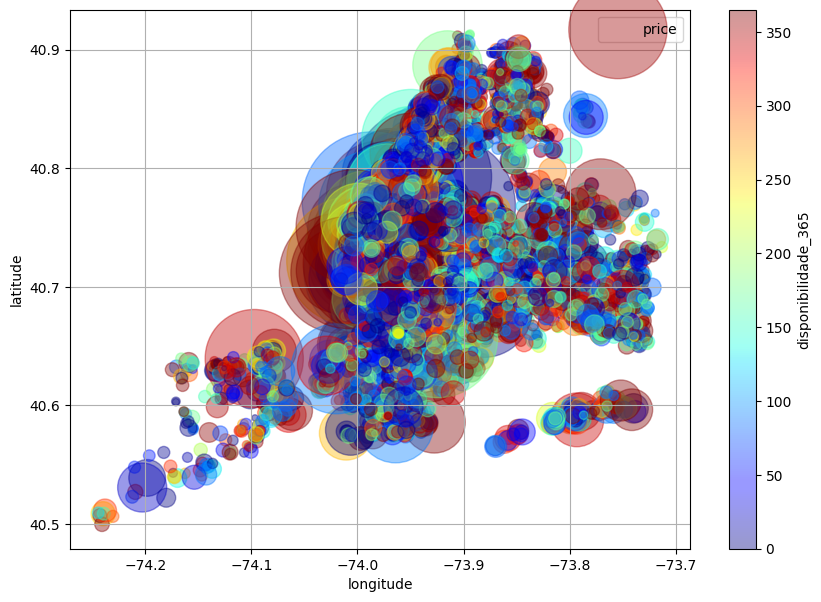

In [11]:
# Análise multivariada
# latitude, longitude, price e disponibilidade_365
scaled_price = df["price"]
df.plot(
    kind="scatter", x="longitude", y="latitude", grid=True,
    s = scaled_price, label="price",
    c="disponibilidade_365", cmap="jet", colorbar=True,
    legend=True, sharex=False, figsize=(10, 7),alpha=0.4)
plt.show()

Com base nesse gráfico, observamos que a menor disponibilidade está localizada no centro, enquanto os preços mais baixos são encontrados em comparação com os outros. Quanto maior o preço, maior é a disponibilidade ao longo do ano.

### A: Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?

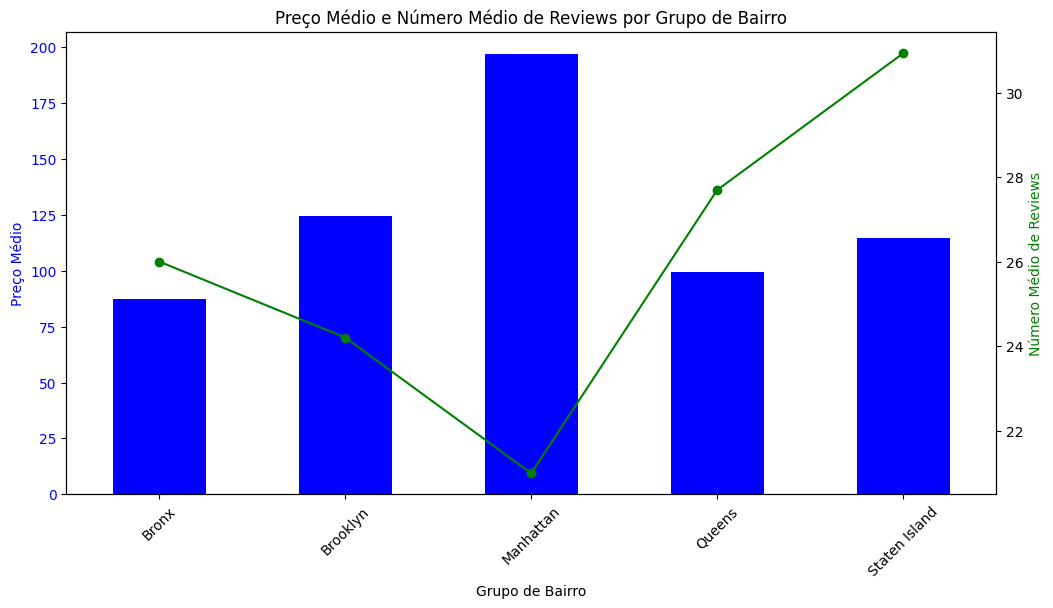

In [ ]:
# Média de preço e número de reviews por grupo de bairro
avg_price_reviews = df.groupby('bairro_group')[['price', 'numero_de_reviews']].mean()

# Cria um gráfico de barras com duas y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Barras para a média de preços
avg_price_reviews['price'].plot(kind='bar', color='b', ax=ax1)
ax1.set_xlabel('Grupo de Bairro')
ax1.set_ylabel('Preço Médio', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Cria um segundo eixo para o número de reviews
ax2 = ax1.twinx()
avg_price_reviews['numero_de_reviews'].plot(kind='line', color='g', ax=ax2, marker='o')
ax2.set_ylabel('Número Médio de Reviews', color='g')

# Ajusta os labels do eixo x para mostrar os nomes dos grupos de bairros
ax1.set_xticklabels(avg_price_reviews.index, rotation=45)

# Título e exibição do gráfico
plt.title('Preço Médio e Número Médio de Reviews por Grupo de Bairro')
plt.show()


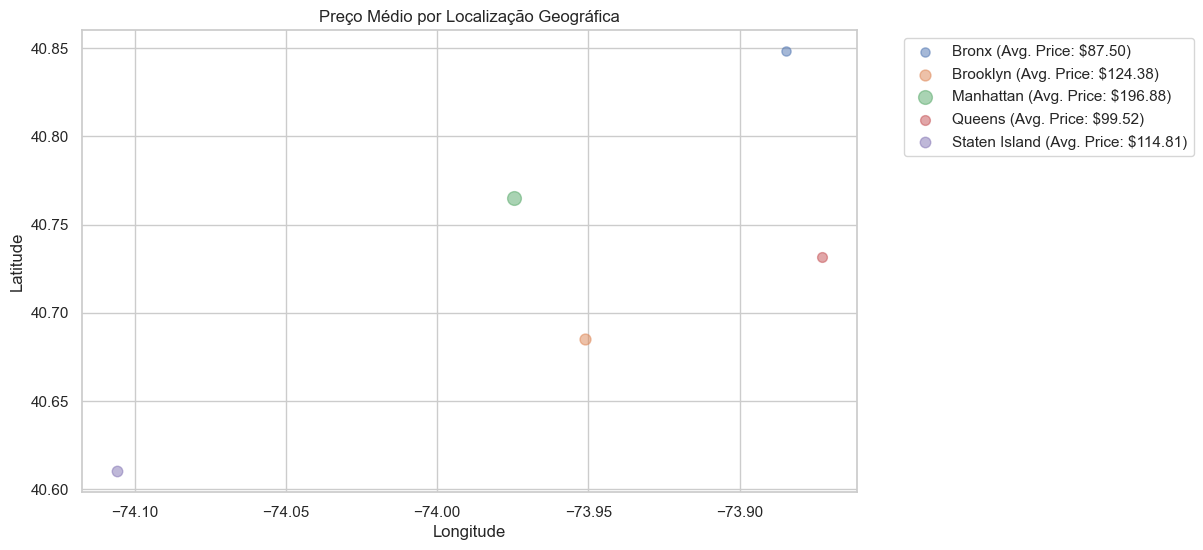

In [ ]:
# Calcula a média de preço, número de reviews, latitude e longitude por grupo de bairro
avg_price_reviews_loc = df.groupby('bairro_group').agg({
    'price': 'mean',
    'numero_de_reviews': 'mean',
    'latitude': 'mean',
    'longitude': 'mean'
}).reset_index()

# Cria um gráfico de bolhas
plt.figure(figsize=(10, 6))

# Cada bairro é representado por uma bolha
for i, row in avg_price_reviews_loc.iterrows():
    plt.scatter(row['longitude'], row['latitude'], 
                s=row['price'] / 2,  # Ajuste a escala conforme necessário
                alpha=0.5, 
                label=f"{row['bairro_group']} (Avg. Price: ${row['price']:.2f})")

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Preço Médio por Localização Geográfica')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


Os grandes grupos mais caros são em manhattan e staten Island então recomendaria entre bronx, Brooklyn e queens

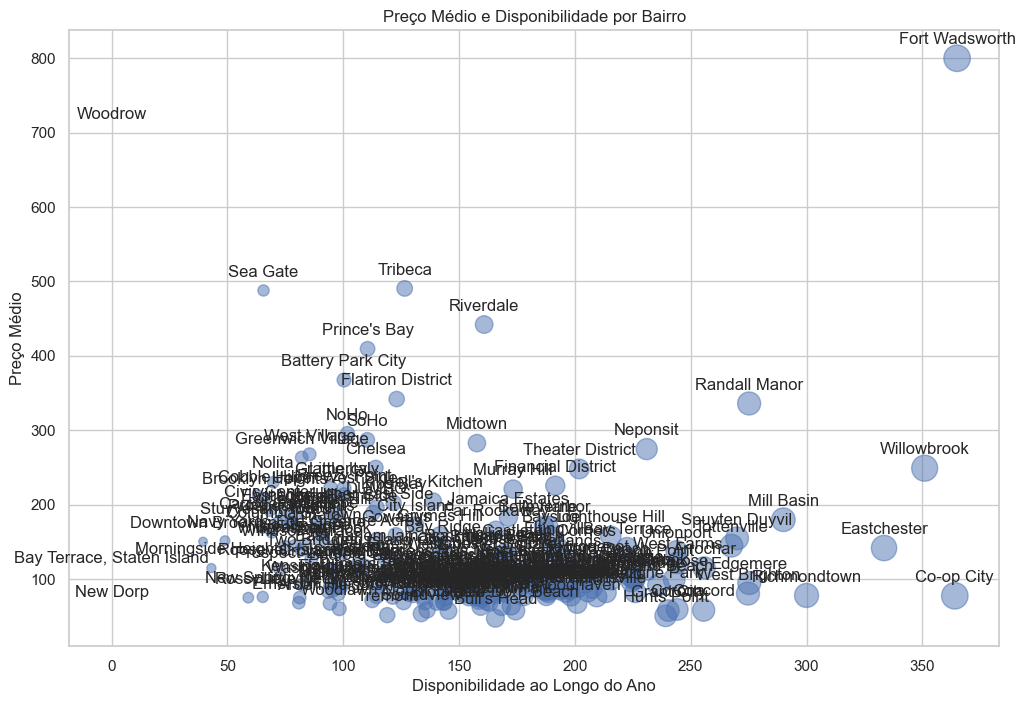

In [ ]:
# Agrupa por bairro e calcula a média do preço e disponibilidade_365
avg_price_availability = df.groupby('bairro').agg({
    'price': 'mean',
    'disponibilidade_365': 'mean'
}).reset_index()

# Cria o gráfico de bolhas
plt.figure(figsize=(12, 8))
scatter = plt.scatter(x=avg_price_availability['disponibilidade_365'], 
                      y=avg_price_availability['price'], 
                      s=avg_price_availability['disponibilidade_365'],
                      alpha=0.5)

# Adiciona rótulos ao gráfico
plt.xlabel('Disponibilidade ao Longo do Ano')
plt.ylabel('Preço Médio')
plt.title('Preço Médio e Disponibilidade por Bairro')

# Adiciona anotações com o nome do bairro
for i, row in avg_price_availability.iterrows():
    plt.annotate(row['bairro'], (row['disponibilidade_365'], row['price']), 
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.show()



Eu sugeriria optar pelo Sea Gate, já que possui uma disponibilidade limitada ao longo do ano e está com um preço moderado. Alternativamente, também pode considerar o Bay Terrace, em Staten Island, onde os preços são mais baixos e a disponibilidade também é limitada ao longo do ano.

### B: O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

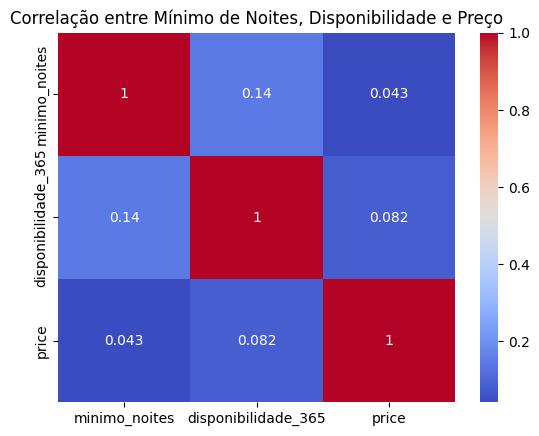

In [ ]:
# Matriz de Correlação
correlation_matrix = df[['minimo_noites', 'disponibilidade_365', 'price']].corr()

# Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlação entre Mínimo de Noites, Disponibilidade e Preço')
plt.show()


Sim, há uma correlação de 0.043 entre o preço e o número mínimo de noites, e uma correlação de 0.082 entre a disponibilidade e o preço.

---

# Iniciando o préprocessamento:

In [15]:
df_temp = df.copy()
df_temp['nome'] = df_temp['nome'].fillna('None').astype(str)
df_temp['host_name'] = df_temp['host_name'].fillna('None').astype(str)
df_temp['host_id'] = df_temp['host_id'].fillna('None')
display(df.head(1))

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355


In [16]:
import nltk

# # Baixando os recursos necessários do NLTK
# nltk.download('punkt')  # Para a tokenização
# nltk.download('stopwords')  # Para a lista de stopwords
# nltk.download('wordnet')  # Para a lematização

# Agora você pode prosseguir com a chamada da função
df_temp = preprocess_text_column(df, 'nome')
display(df_temp.head(1))

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,"[skylit, midtown, castle]",2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355


### C: Existe algum padrão no texto do nome do local para lugares de mais alto valor?



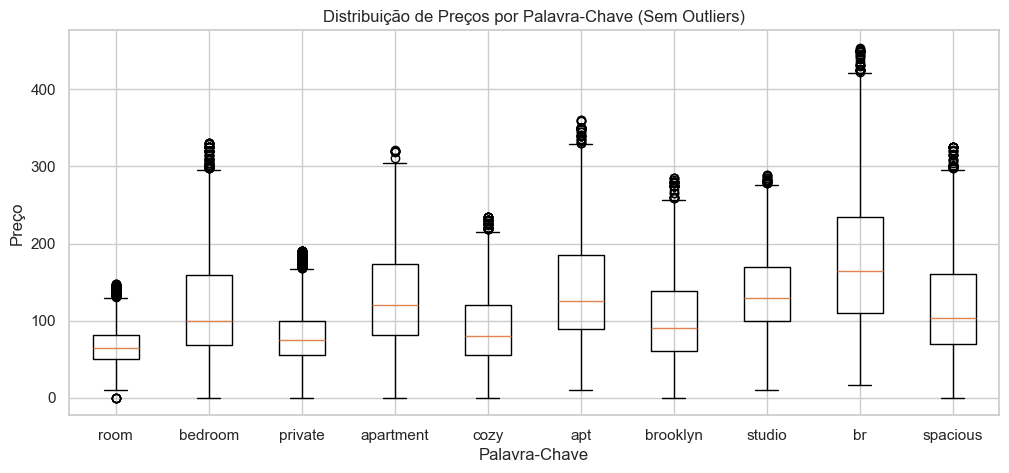

In [39]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_temp_2 = df_temp.copy()

# Criando um contador para todas as palavras
word_counter = Counter()
df_temp_2['nome'].apply(word_counter.update)

# Encontrando as palavras mais comuns
most_common_words = word_counter.most_common(10)  # Ajuste o número conforme desejado

# Extraindo apenas as palavras, sem as contagens
keywords = [word for word, count in most_common_words]

# Preparando os dados
data_to_plot = [remove_outliers(df_temp_2[df_temp_2['nome'].apply(lambda x: keyword in x)], 'price')['price'] for keyword in keywords]

# Criando boxplots
plt.figure(figsize=(12, 5))
plt.boxplot(data_to_plot, labels=keywords)
plt.title('Distribuição de Preços por Palavra-Chave (Sem Outliers)')
plt.xlabel('Palavra-Chave')
plt.ylabel('Preço')
plt.show()

# Então sim as palavras tem impacto no preço


In [18]:
# Como o host_id é unico para cada anunciante irei transformar o nome do anunciante em uma aproximação pelo genero

df_temp = gender_guess(df_temp, 'host_name')
display(df_temp.head(1))

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,genero
0,2595,"[skylit, midtown, castle]",2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,female


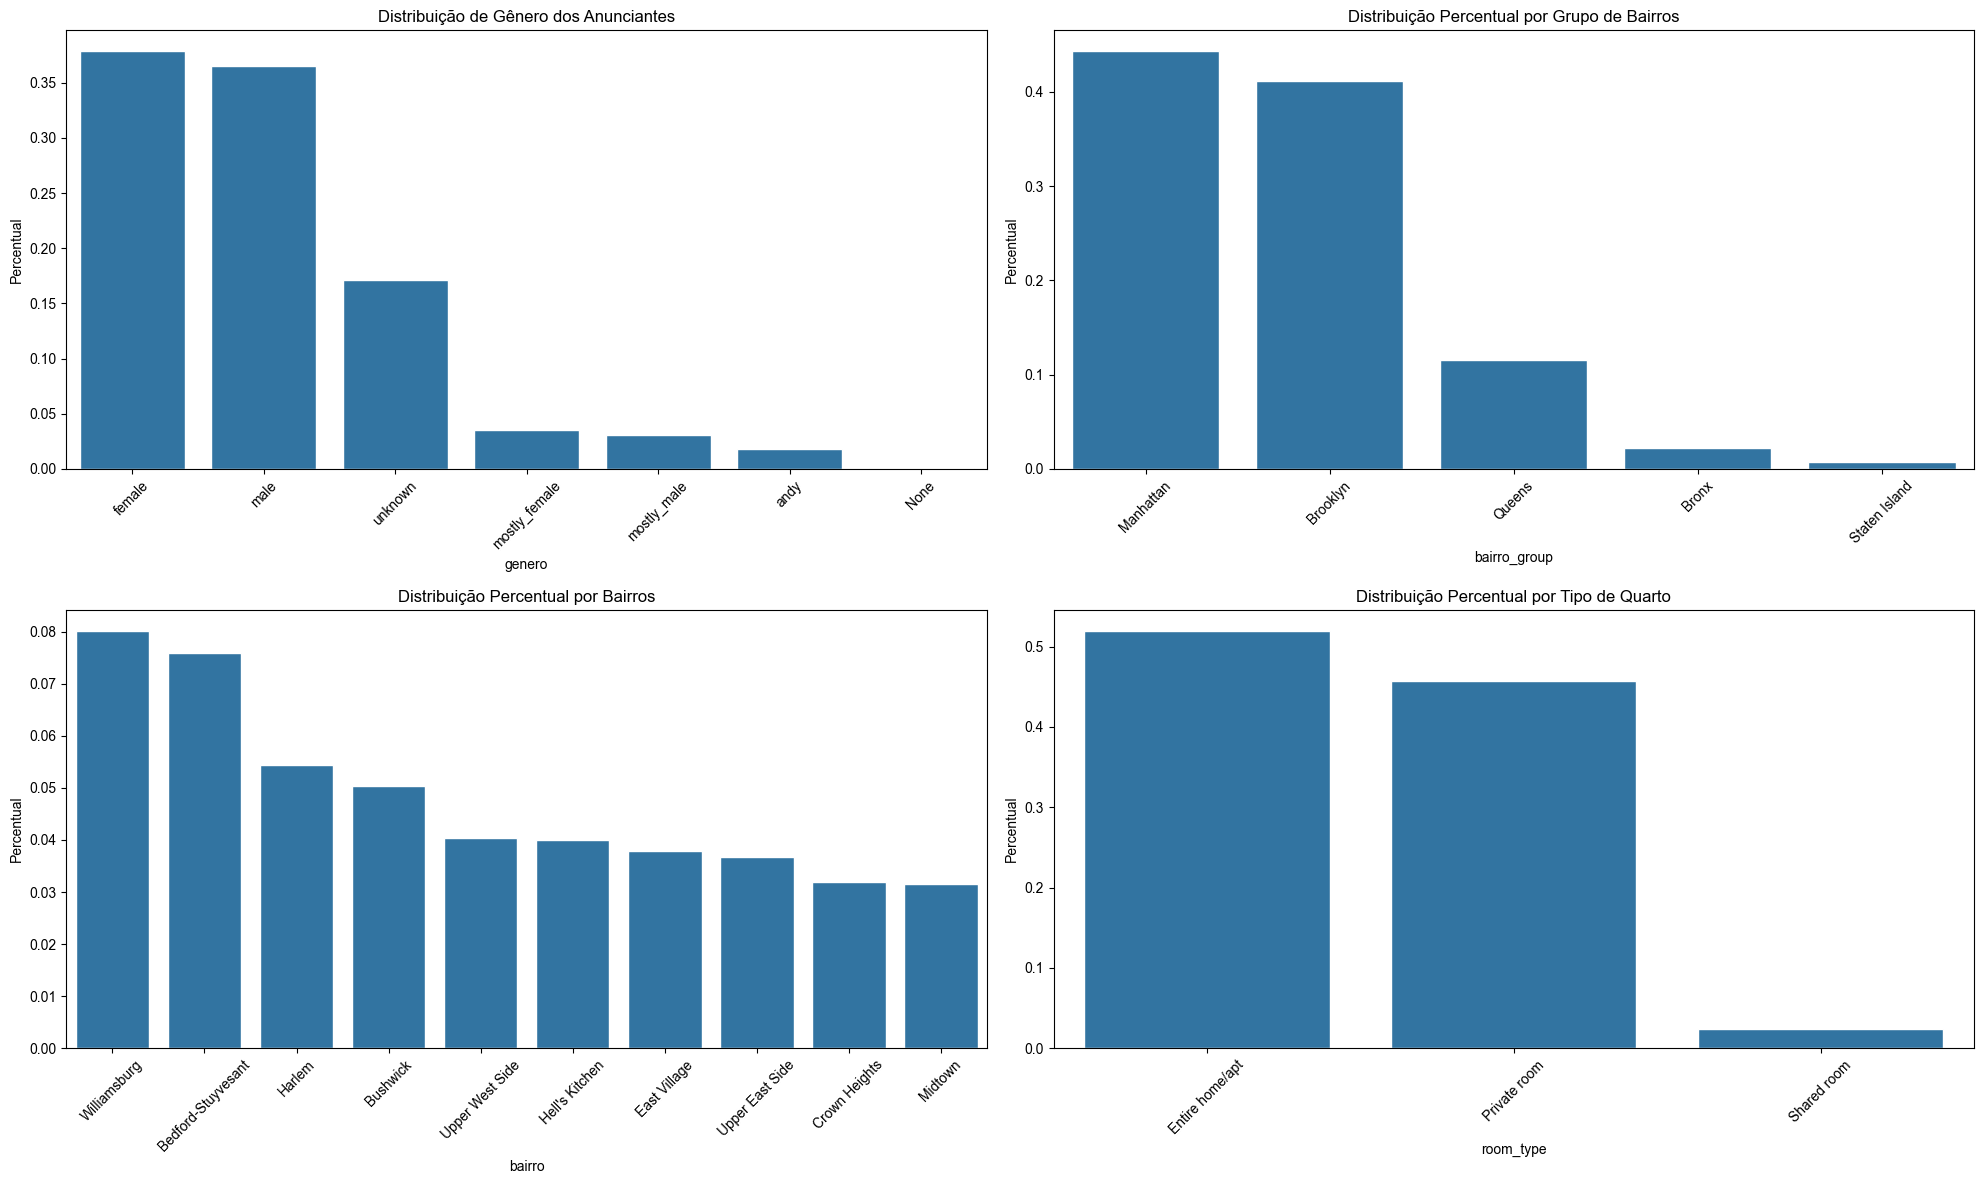

In [19]:
# Analisando frequência de variaveis categoricas
fig, axes = plt.subplots(2, 2, figsize=(20, 12))  # Ajuste o número de subplots aqui

plot_bar_with_style(df_temp, 'genero', title='Distribuição de Gênero dos Anunciantes', ax=axes[0, 0])
plot_bar_with_style(df_temp, 'bairro_group', title='Distribuição Percentual por Grupo de Bairros', ax=axes[0, 1])
plot_bar_with_style(df_temp, 'bairro', title='Distribuição Percentual por Bairros', limit=10, ax=axes[1, 0])
plot_bar_with_style(df_temp, 'room_type', title='Distribuição Percentual por Tipo de Quarto', ax=axes[1, 1])

plt.tight_layout()
plt.show()

In [20]:
# Tratando o ultimo review para que seja possivel analisar a diferença entre a data do ultimo review e a data de hoje

df_temp['last_review'] = pd.to_datetime(df_temp['ultima_review']) - pd.to_datetime(df_temp['ultima_review']).max() # Foi utilizado o max para simular a data de hoje
df_temp['last_review'] = df_temp['last_review'].dt.days
display(df_temp.head(1))

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,genero,last_review
0,2595,"[skylit, midtown, castle]",2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,female,-48.0


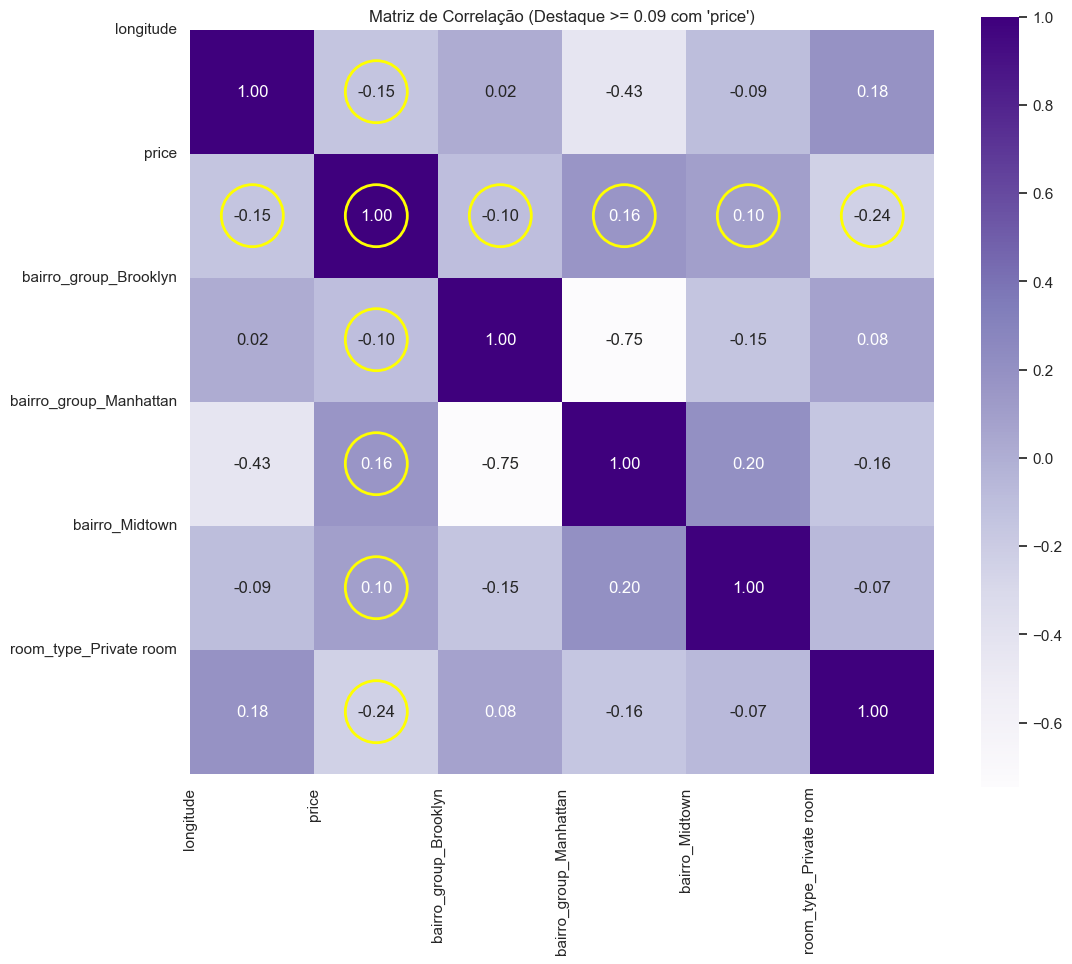

In [25]:
df_corr_plot = preprocess_complete(df_temp.drop(['id', 'nome', 'host_name', 'ultima_review'], axis=1))
plot_correlacao(df_corr_plot, valor_minimo_correlacao=0.09)

# Após o préprocessamento diversas colunas apresentam correlação acima de 0.09

---

## Treinamento

In [43]:
df_temp = df.copy()
df_temp['nome'] = df_temp['nome'].fillna('None').astype(str)
df_temp['host_name'] = df_temp['host_name'].fillna('None').astype(str)
df_temp['host_id'] = df_temp['host_id'].fillna('None')
df_temp = preprocess_text_column(df, 'nome')
df_temp = gender_guess(df_temp, 'host_name')
df_temp['last_review'] = pd.to_datetime(df_temp['ultima_review']) - pd.to_datetime(df_temp['ultima_review']).max() # Foi utilizado o max para simular a data de hoje
df_temp['last_review'] = df_temp['last_review'].dt.days

In [44]:
df_temp.tail(1)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,genero,last_review
0,2595,"[skylit, midtown, castle]",2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,female,-48.0


In [45]:
#nome_temp = df_temp['nome']
X = df_temp.drop(['id', 'nome', 'host_name', 'ultima_review', 'price'], axis=1)
y = df_temp['price']
display(X.head(1))

X = preprocess_complete(X)
X_eval = X.tail(1)
y_eval = y.tail(1)
X = X.drop(X.tail(1).index)
y = y.drop(y.tail(1).index)
display(X.head(1))

,host_id,bairro_group,bairro,latitude,longitude,room_type,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,genero,last_review
0,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,1,45,0.38,2,355,female,-48.0


,host_id,latitude,longitude,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,last_review,bairro_group_Brooklyn,...,bairro_Woodrow,bairro_Woodside,room_type_Private room,room_type_Shared room,genero_andy,genero_female,genero_male,genero_mostly_female,genero_mostly_male,genero_unknown
1,-0.860127,1.468375,0.222499,-0.196482,-0.522444,-0.341211,-0.186447,1.916238,0.474202,0,...,0,0,1,0,0,1,0,0,0,0


In [49]:
y

1        150
2         89
3         80
4        200
5         60
        ... 
48889     70
48890     40
48891    115
48892     55
48893     90
Name: price, Length: 48893, dtype: int64

In [61]:
import pickle

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1 / 3, random_state=42
)

# df_result, model_stack = train_models_and_stacking_REGRESSOR(X_train, X_test, y_train, y_test)
# df_result.to_csv('data/resultado_train.csv', index=False)
# filename = 'model/stacked_model.pkl'
# with open(filename, 'wb') as file:
#     pickle.dump(model_stack, file)


df_result = pd.read_csv("data/resultado_train.csv")
display(df_result.sort_values("MAE").head(10))
with open("model/stacked_model.pkl", "rb") as file:
    model = pickle.load(file)

# O stacking foi feito utilizando os 5 melhores modelos

,Tipo,Models,MAE,MSE,RMSE,EVS,Time
18,Stacking,Stacking,65.062053,56779.484994,238.284462,0.162819,429.817690
9,Linear,PassiveAggressiveRegressor,65.551435,63034.904214,251.067529,0.087221,0.463951
17,Boosting,CatBoostRegressor,66.922585,57927.054557,240.680399,0.145888,4.574104
10,Ensemble,RandomForestRegressor,67.391483,60353.830545,245.670166,0.110121,40.773364
11,Ensemble,GradientBoostingRegressor,67.558158,58683.081388,242.245911,0.134764,10.340908
12,Ensemble,ExtraTreesRegressor,69.112333,64015.545969,253.012936,0.056138,37.533114
16,Boosting,XGBRegressor,69.451566,62475.642313,249.951280,0.078770,0.751155
14,Ensemble,BaggingRegressor,70.131096,61821.985799,248.640274,0.088417,4.609737
7,Linear,SGDRegressor,70.796814,61200.104733,247.386549,0.097924,0.817312
3,Linear,BayesianRidge,71.837525,61131.935004,247.248731,0.098666,0.588961


In [62]:
y_recomendado = model.predict(X_eval)[0]

# O valor recomendado para o row é 
print("O valor recomendado para o row é ", y_recomendado)

O valor recomendado para o row é  302.9699025018577


c:\Isaac\Faculdade\programing\env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
c:\Isaac\Faculdade\programing\env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Isaac\Faculdade\programing\env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  warnings.warn(
c:\Isaac\Faculdade\programing\env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LassoCV was fitted without feature names
  warnings.warn(
